# TP IMAGES SICOM 2A - CORRELATION

In [206]:
import numpy as np
import skimage.io as skio 
import skimage.util as skutil
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.fftpack as sc
import skimage.filters as skf
import skimage.color as skc
import skimage.morphology as skm
from skimage.transform import resize 
from skimage import img_as_ubyte 
from scipy.ndimage import shift 
import cv2

## Introduction

## Corrélation

### Autocorrélation

(<AxesSubplot:title={'center':'Disk'}>,
 Text(0.5, 1.0, 'Disk'))

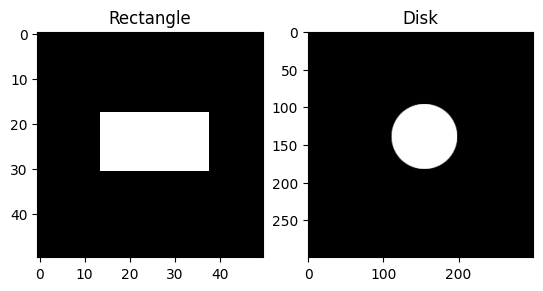

In [182]:
rect_img = skio.imread('rectangle.png', as_gray=True)
circ_img = skio.imread('disk.png', as_gray=True)
plt.subplot(1,2,1), plt.imshow(rect_img, cmap='gray'), plt.title('Rectangle')
plt.subplot(1,2,2), plt.imshow(circ_img, cmap='gray'), plt.title('Disk')

(<matplotlib.image.AxesImage at 0x263fbac08b0>,
 Text(0.5, 1.0, 'Rectangle autocorrelation'))

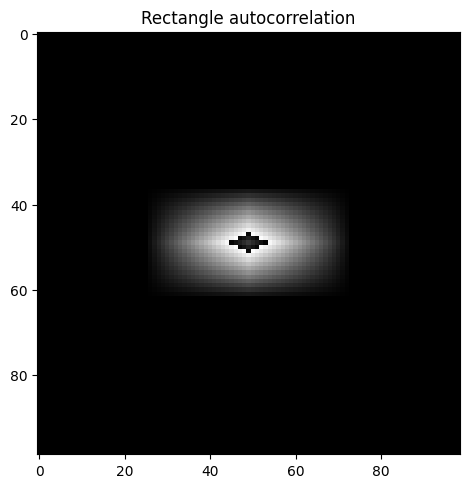

In [183]:
rect_autocorr = sig.correlate2d(rect_img, rect_img)
skio.imshow(rect_autocorr, cmap='gray'), plt.title('Rectangle autocorrelation')

On voit qu'il y a un problème au centre de l'image. Les coordonnées pour lesquelles ont devrait avoir la plus forte valeur d'autocorrélation ont des valeurs quasi nulles (noir). Cela est sûrement dû au fait que nos images ne correspondent pas à des signaux centrés. Pour ces derniers, le calcul de l'autocorrélation est biaisé par la moyenne du signal. Tentons de centrer les valeurs de nos images. 

(<matplotlib.image.AxesImage at 0x263fbb23f70>,
 Text(0.5, 1.0, 'Rectangle autocorrelation with centered image'))

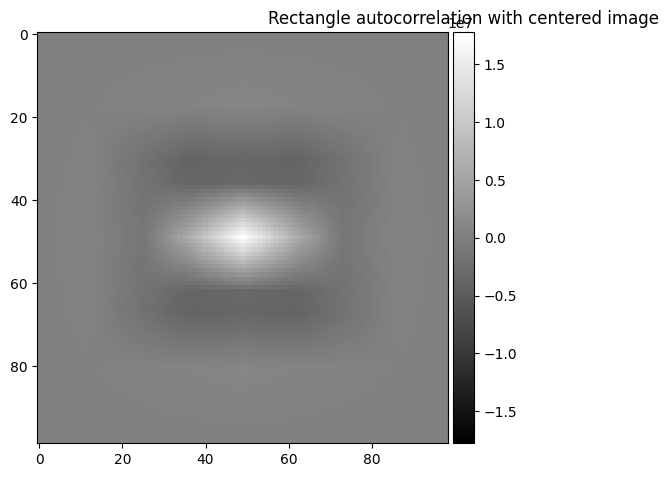

In [184]:
rect_img = rect_img - np.mean(rect_img)
new_rect_autocorr = sig.correlate(rect_img, rect_img)
skio.imshow(new_rect_autocorr, cmap='gray'), plt.title('Rectangle autocorrelation with centered image')

Réalisons cela pour le disque. 

(<AxesSubplot:title={'center':'Disk autocorrelation with centered image'}>,
 Text(0.5, 1.0, 'Disk autocorrelation with centered image'))

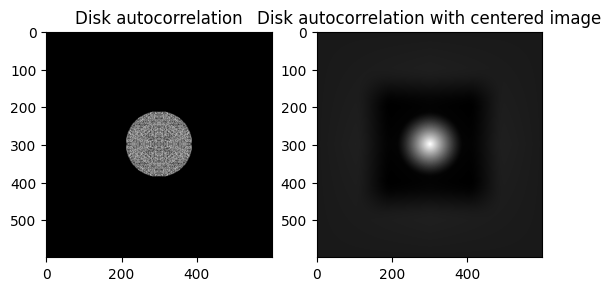

In [185]:
circle_autocorr = sig.correlate(circ_img, circ_img)
circ_img = circ_img - np.mean(circ_img)
new_circle_autocorr = sig.correlate(circ_img, circ_img)
plt.subplot(1,2,1), plt.imshow(circle_autocorr, cmap='gray'), plt.title('Disk autocorrelation')
plt.subplot(1,2,2), plt.imshow(new_circle_autocorr, cmap='gray'), plt.title('Disk autocorrelation with centered image')

### Vitesse d'écoulement d'un fluide

(<AxesSubplot:title={'center':'Fluid image 2'}>,
 Text(0.5, 1.0, 'Fluid image 2'))

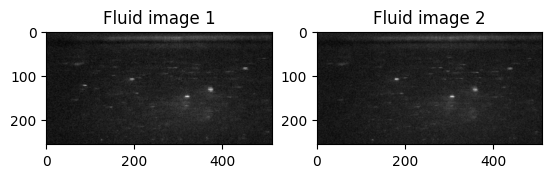

In [186]:
fluid_img1 = skio.imread('vitesse1.bmp', as_gray=True)
fluid_img2 = skio.imread('vitesse2.bmp', as_gray=True)

plt.subplot(1,2,1), plt.imshow(fluid_img1, cmap='gray'), plt.title('Fluid image 1')
plt.subplot(1,2,2), plt.imshow(fluid_img2, cmap='gray'), plt.title('Fluid image 2')

Comme nous avons accès à la durée entre la prise des deux photos, trouvons la distance parcourue par le fluide pendant cette durée pour remonter à la vitesse grâce à la formule $ v = d/t $. 

Calculons l'autocorrélation de nos deux images. Si on prend le point où la corrélation est maximale, on a accès au nombre de pixels séparant les deux images. En effet le maximum de l'autocorrélation d'une image est situé au centre de l'image. Donc la distance parcouru par le fluide est: $ |x_{center, img} - x_{max, autocorr}| $ 

(<matplotlib.image.AxesImage at 0x263d8d9e4f0>,
 Text(0.5, 1.0, 'Fluid autocorrelation'))

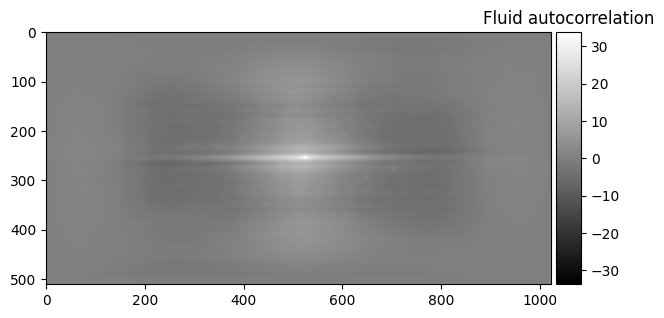

In [187]:
fluid_img1 = fluid_img1 - np.mean(fluid_img1)
fluid_img2 = fluid_img2 - np.mean(fluid_img2)
fluid_autocorr = sig.correlate(fluid_img1, fluid_img2)
skio.imshow(fluid_autocorr, cmap='gray'), plt.title('Fluid autocorrelation')

On calcule la position de notre maximum dans l'image puis la distance entre les deux images. On pense à multiplier par 0.001 la distance car 1 pixel sur l'image représente 1 mm dans la réalité. 

In [120]:
index = np.where(np.max(fluid_autocorr) == fluid_autocorr)
x_max_autocorr = index[1][0]
distance = abs(x_max_autocorr - fluid_autocorr.shape[1]/2) * 0.001

In [121]:
duree = 5 # msecondes
vitesse = distance/duree    
print("La vitesse est de", vitesse, "m/s.")

La vitesse est de 0.0027 m/s.


## Corrélation de phase

### Partition de musique
Le but ici est de retrouver la clé de sol dans une partition. 

La partition est de taille (144, 391)
La clé de sol est de taille (362, 128)


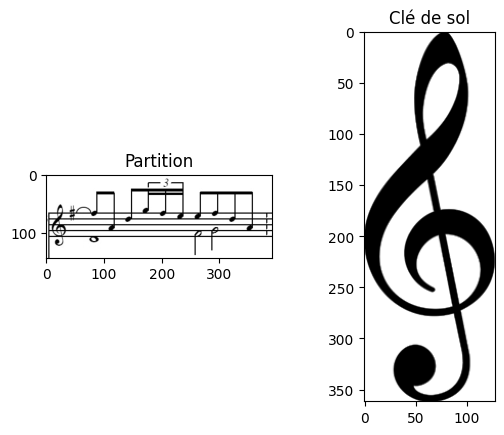

In [188]:
part = skio.imread('partition.png', as_gray=True)
clesol = skio.imread('clesol.bmp', as_gray=True)
plt.subplot(1,2,1), plt.imshow(part, cmap='gray'), plt.title('Partition')
plt.subplot(1,2,2), plt.imshow(clesol, cmap='gray'), plt.title('Clé de sol')
print("La partition est de taille", part.shape)
print("La clé de sol est de taille", clesol.shape)

Pour cela, on a recourt à la corrélation de phase qui permet d'estimer le décalage entre deux images. Afin d'utiliser cette technique, nous devons avoir les deux clés de sol à la même taille. 
A la main on mesure que la clé de sol dans la partition mesure 71 pixels de haut et 24 de large. 

(<matplotlib.image.AxesImage at 0x263f4b5eb80>,
 Text(0.5, 1.0, 'Clé de sol redimensionnée'))

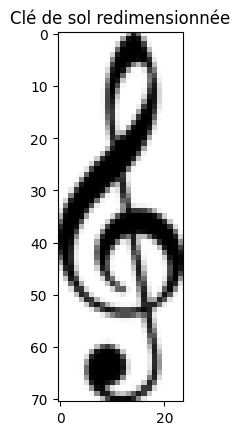

In [189]:
clesol = resize(clesol, (71, 24))
plt.imshow(clesol, cmap='gray'), plt.title('Clé de sol redimensionnée')

On calcule les TF en faisant du zéro padding pour l'image de la clé de sol

(<matplotlib.image.AxesImage at 0x263f4bc3370>,
 Text(0.5, 1.0, 'Clé de sol avec zéro-padding'))

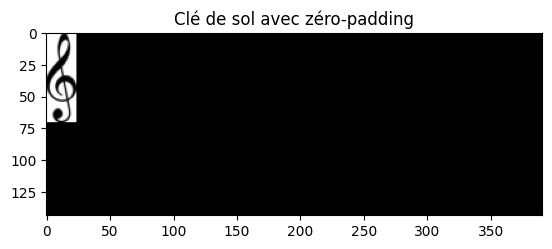

In [190]:
clesol_tf = sc.fft2(clesol, shape=part.shape) # transformée de Fourier de la clé de sol avec zéro-padding
clesol_zp = sc.ifft2(clesol_tf) # image de la clé de sol avec zéro-padding
clesol_zp = np.abs(clesol_zp) # valeur absolue de l'image de la clé de sol

plt.imshow(clesol_zp, cmap='gray'), plt.title('Clé de sol avec zéro-padding')

Calculons désormais la corrélation de phase des deux images. Les coordonnées de différence entre les deux images sont ceux pour lesquels la différence de phase est maximale. 

In [155]:
TFI=sc.fftshift(clesol_tf) # mettre 0 au centre de l'image

part_tf = sc.fft2(part) # transformée de Fourier de la partition
TFP=sc.fftshift(part_tf) # mettre 0 au centre de l'image

clesol_tf_conj = np.conjugate(clesol_tf) # conjugue de la transformée de Fourier de la clé de sol

diff_phase = sc.ifft2((part_tf*clesol_tf_conj) / np.abs(part_tf*clesol_tf_conj)) # différence de phase

y, x = np.unravel_index(np.argmax(diff_phase), diff_phase.shape) # coordonnées du maximum de la différence de phase
print("La clé de sol est décalée de", x, "en x et de", y, "en y.")

La clé de sol est décalée de 10 en x et de 52 en y.


Traçons maintenant où notre calcul estime la position de la clé de sol dans la partition. Pour cela nous traçons un rectangle dont l'origine a pour coordonnées ceux donnés par la différence de phase. On trace un rectangle de la taille de la clé de sol. 

(<matplotlib.image.AxesImage at 0x263fbbdd160>,
 Text(0.5, 1.0, 'Partition avec estimation de la position de la clé de sol'))

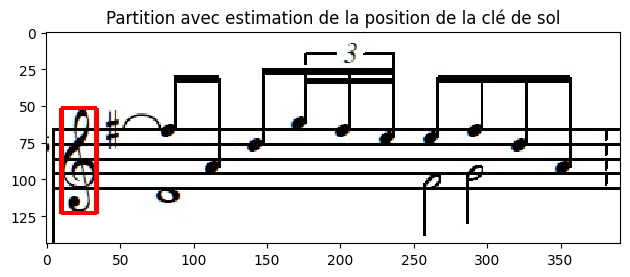

In [191]:
part_color = cv2.imread('partition.png')
cv2.rectangle(part_color, (x, y), (x+24, y+71), color=(255, 0, 0), thickness=2) # rectangle de la clé de sol
skio.imshow(part_color), plt.title('Partition avec estimation de la position de la clé de sol')

Nous pouvons observer que le rectangle tracé correspond bien à la position de la clé de sol dans la partition. 

## Tokens
On cherche ici à estimer les coordonnées des centres des tokens sur une image à l'aide de la corrélation. 

(<matplotlib.image.AxesImage at 0x263feea8d90>, Text(0.5, 1.0, 'Tokens'))

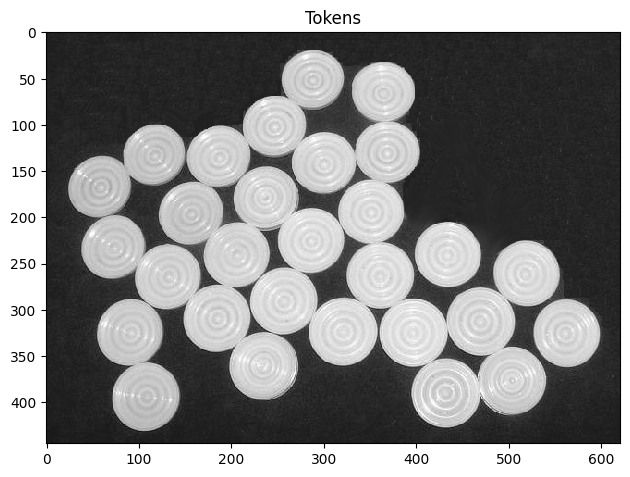

In [193]:
tokens = skio.imread("tokens.tif")
skio.imshow(tokens), plt.title('Tokens')

Comme pour l'exercice précédent de la clé de sol, il nous fait une image de référence. Nous découpons alors un des tokens de l'image pour créer une image contenant un seul token. 

(<matplotlib.image.AxesImage at 0x263feefcdf0>,
 Text(0.5, 1.0, 'Token seul avec zéro-padding'))

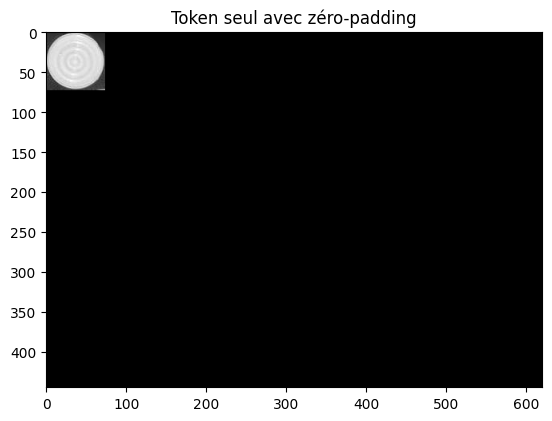

In [194]:
one_token = skio.imread("one_token.jpeg")
one_token_tf = sc.fft2(one_token, shape=tokens.shape) # transformée de Fourier de la clé de sol avec zéro-padding
one_token_zp = sc.ifft2(one_token_tf) # image de la clé de sol avec zéro-padding
one_token_zp = np.abs(one_token_zp) # valeur absolue de l'image de la clé de sol

plt.imshow(one_token_zp, cmap='gray'), plt.title('Token seul avec zéro-padding')

Calculons la différence de phase entre les deux images. 

In [180]:
one_token_tf=sc.fftshift(one_token_tf) # mettre 0 au centre de l'image

tokens_tf = sc.fftshift(sc.fft2(tokens)) # transformée de Fourier de la partition

one_token_tf_conj = np.conjugate(one_token_tf) # conjugue de la transformée de Fourier de la clé de sol

diff_phase = abs(sc.ifft2((tokens_tf*one_token_tf_conj) / np.abs(tokens_tf*one_token_tf_conj))) # différence de phase

En seuillant notre différence de phase afin de garder uniquement les valeurs pour lesquelles la corrélation est la plus forte, nous pouvons afficher la position estimée des pièces dans l'image.

(<matplotlib.image.AxesImage at 0x263fc098880>,
 Text(0.5, 1.0, 'Tokens repérés'))

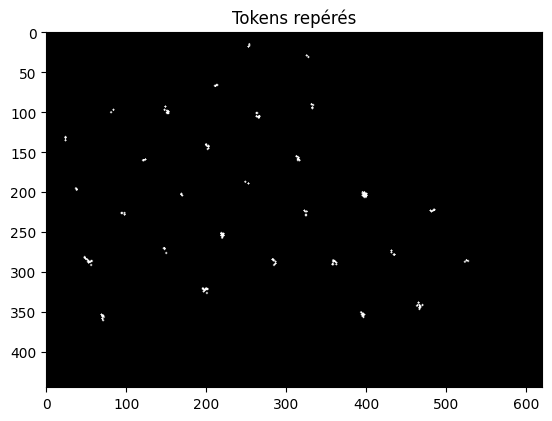

In [195]:
threshold = 0.012
repered_tokens = diff_phase > threshold

repered_tokens = skm.dilation(repered_tokens, skm.disk(1))
plt.imshow(repered_tokens, cmap='gray'), plt.title('Tokens repérés')

## Destroy contest
Le but de cet exercice est de décaler artificiellement une image puis d'utiliser la technique de différence de phase vue précédemment afin de retrouver le décalage imposé. 

(<matplotlib.image.AxesImage at 0x263fa985df0>, Text(0.5, 1.0, 'Bulles'))

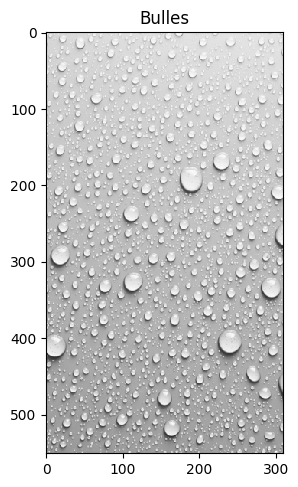

In [208]:
bubbles = skio.imread("bubble.png")
bubbles = skc.rgb2gray(bubbles)
skio.imshow(bubbles, cmap='gray'), plt.title('Bulles')

Décalons l'image de 10 en x et de 20 en y. 

(<matplotlib.image.AxesImage at 0x263feab28e0>,
 Text(0.5, 1.0, 'Bulles décalées'))

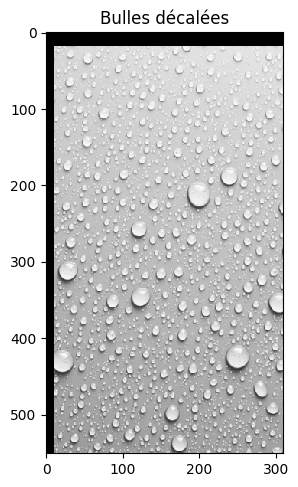

In [209]:
shifted_bubbles = shift(bubbles, [20, 10])
skio.imshow(shifted_bubbles), plt.title('Bulles décalées')

Cet exercice n'a pas pu être abouti par manque de temps. 

## Conclusion
Ce TP a permis de mettre en évidence les en quoi la corrélation peut être très utile en traitement d'images. La corrélation classique permet par exemple de trouver la distance qui sépare deux images et donc de déterminer la vitesse d'un fluide entre deux prises. La corrélation de phase permet quant à elle de déterminer de combien de pixels une image a été shifté en abscisses et en ordonnées. Cela peut être utile pour retrouver des objets dans une image. En revanche, il faut faire attention à mettre en forme les images avant tout calcul d'autocorrélation. En effet, les images ne sont pas des processus centrés et il faut donc veiller à retirer leur moyenne. 